In [13]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from google.colab import files


In [14]:
IMG_SIZE = 128
bw_path = '/content/drive/MyDrive/manga-dataset/bw'
color_path = '/content/drive/MyDrive/manga-dataset/color'

def load_images_random_pairing(bw_path, color_path):
    bw_imgs = []
    color_imgs = []

    bw_files = sorted(os.listdir(bw_path))
    color_files = sorted(os.listdir(color_path))

    n = min(len(bw_files), len(color_files))  # gunakan jumlah minimum

    random.shuffle(bw_files)
    random.shuffle(color_files)

    for i in range(n):
        bw = load_img(os.path.join(bw_path, bw_files[i]), color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))
        color = load_img(os.path.join(color_path, color_files[i]), target_size=(IMG_SIZE, IMG_SIZE))

        bw_imgs.append(img_to_array(bw) / 255.0)
        color_imgs.append(img_to_array(color) / 255.0)

    return np.array(bw_imgs), np.array(color_imgs)

bw_images, color_images = load_images_random_pairing(bw_path, color_path)

print("Shape BW:", bw_images.shape)
print("Shape Color:", color_images.shape)


Shape BW: (20, 128, 128, 1)
Shape Color: (20, 128, 128, 3)


In [15]:
input_img = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 3)    │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,163 (2.55 MB)

 Trainable params: 668,163 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(bw_images, color_images, test_size=0.2, random_state=42)

autoencoder.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                batch_size=4, epochs=50)

autoencoder.save('/content/drive/MyDrive/manga-dataset/manga_colorizer.h5')


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.1330 - val_loss: 0.1445
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.1308 - val_loss: 0.1399
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.1246 - val_loss: 0.1396
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.1222 - val_loss: 0.1375
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.1305 - val_loss: 0.1394
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.1262 - val_loss: 0.1373
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.1309 - val_loss: 0.1375
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.1284 - val_loss: 0.1367
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.1253 - val_loss: 0.1363
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.1270 - val_loss: 0.1357
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.1217 - val_loss: 0.1351
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.1187 - val_loss: 0.1342
Epoch 13/50
4/4 ━━━━

Saving 9.png to 9.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


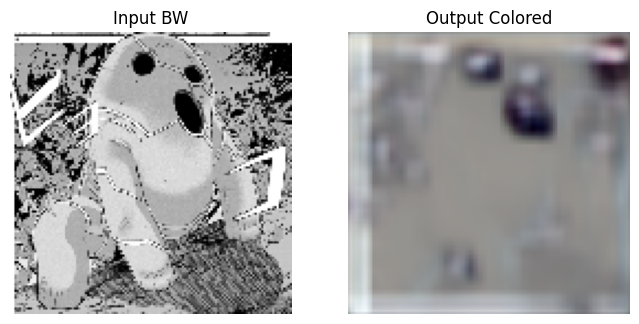

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

# 1. Upload gambar hitam putih dari lokal
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# 2. Load model tanpa compile ulang
model = load_model('/content/drive/MyDrive/manga-dataset/manga_colorizer.h5', compile=False)

# 3. Proses gambar input
IMG_SIZE = 128
bw_img = load_img(file_name, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))
bw_arr = img_to_array(bw_img) / 255.0
bw_arr = np.expand_dims(bw_arr, axis=0)  # Tambahkan batch dimensi

# 4. Prediksi pewarnaan
output = model.predict(bw_arr)
output_img = array_to_img(output[0])

# 5. Tampilkan input dan hasil
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Input BW")
plt.imshow(bw_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Output Colored")
plt.imshow(output_img)
plt.axis('off')

plt.show()

# 6. Simpan hasil pewarnaan dan download
output_img.save("output_colored.png")
files.download("output_colored.png")


In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

color_path = '/content/drive/MyDrive/manga-dataset/color/'
IMG_SIZE = 128


In [32]:
def load_self_supervised_data(color_path):
    color_imgs = []
    bw_imgs = []

    for fname in os.listdir(color_path):
        path = os.path.join(color_path, fname)
        try:
            img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
            img_color = img_to_array(img) / 255.0
            img_gray = img_to_array(load_img(path, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))) / 255.0

            color_imgs.append(img_color)
            bw_imgs.append(np.expand_dims(img_gray, axis=2))  # shape jadi (128,128,1)
        except:
            print("Gagal load:", fname)

    return np.array(bw_imgs), np.array(color_imgs)

bw_images, color_images = load_self_supervised_data(color_path)
print("Shape BW:", bw_images.shape)
print("Shape Color:", color_images.shape)


Shape BW: (20, 128, 128, 1, 1)
Shape Color: (20, 128, 128, 3)


In [33]:
input_img = Input(shape=(IMG_SIZE, IMG_SIZE, 1))  # Input BW

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

output_img = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output RGB

model = Model(input_img, output_img)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,603 (1.14 MB)

 Trainable params: 297,603 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(bw_images, color_images, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=8,
                    validation_data=(X_val, y_val))


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.1477 - val_loss: 0.1215
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.1259 - val_loss: 0.0933
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.1211 - val_loss: 0.0936
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.1039 - val_loss: 0.0901
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0987 - val_loss: 0.0791
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0897 - val_loss: 0.0681
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - loss: 0.0758 - val_loss: 0.0594
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0687 - val_loss: 0.0538
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0606 - val_loss: 0.0519
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0607 - val_loss: 0.0584
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0572 - val_loss: 0.0521
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0558 - val_loss: 0.0465
Epoch 13/50
2/2 ━━━━━━━━━

In [35]:
model.save('/content/drive/MyDrive/manga-dataset/manga_colorizer_selfsupervised.h5')


Saving 9.png to 9 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


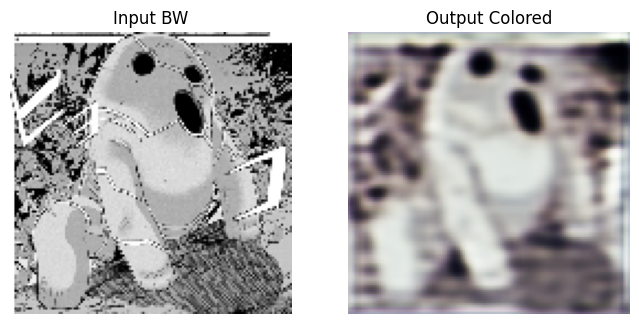

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

# 1. Upload gambar hitam putih dari lokal
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# 2. Load model tanpa compile ulang
model = load_model('/content/drive/MyDrive/manga-dataset/manga_colorizer_selfsupervised.h5', compile=False)

# 3. Proses gambar input
IMG_SIZE = 128
bw_img = load_img(file_name, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))
bw_arr = img_to_array(bw_img) / 255.0
bw_arr = np.expand_dims(bw_arr, axis=0)  # Tambahkan batch dimensi

# 4. Prediksi pewarnaan
output = model.predict(bw_arr)
output_img = array_to_img(output[0])

# 5. Tampilkan input dan hasil
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Input BW")
plt.imshow(bw_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Output Colored")
plt.imshow(output_img)
plt.axis('off')

plt.show()

# 6. Simpan hasil pewarnaan dan download
output_img.save("output_colored.png")
files.download("output_colored.png")


In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam


IMG_SIZE = 128
color_path = '/content/drive/MyDrive/manga-dataset/color/'

def load_self_supervised_data(color_path):
    color_imgs = []
    bw_imgs = []

    for fname in os.listdir(color_path):
        path = os.path.join(color_path, fname)
        try:
            img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
            img_color = img_to_array(img) / 255.0
            img_gray = img_to_array(load_img(path, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))) / 255.0

            color_imgs.append(img_color)
            bw_imgs.append(np.expand_dims(img_gray, axis=2))
        except:
            print("Skip:", fname)

    return np.array(bw_imgs), np.array(color_imgs)

bw_images, color_images = load_self_supervised_data(color_path)
X_train, X_val, y_train, y_val = train_test_split(bw_images, color_images, test_size=0.2, random_state=42)

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam


def unet(input_size=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    # Bottleneck
    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)

    # Decoder
    u4 = UpSampling2D()(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, 3, activation='relu', padding='same')(u4)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    u5 = UpSampling2D()(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model

model = unet()
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_44[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_46[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ conv2d_47[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_48[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_10    │ (None, 64, 64,    │          0 │ conv2d_49[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64,    │          0 │ up_sampling2d_10… │
│ (Concatenate)       │ 384)              │            │ conv2d_47[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 64, 64,    │    442,496 │ concatenate_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_50[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_11    │ (None, 128, 128,  │          0 │ conv2d_51[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128, 128,  │          0 │ up_sampling2d_11… │
│ (Concatenate)       │ 192)              │            │ conv2d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 128, 128,  │    110,656 │ concatenate_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_52[0][0] 

 Total params: 1,882,115 (7.18 MB)

 Trainable params: 1,882,115 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=4)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - loss: 0.1437 - val_loss: 0.1425
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - loss: 0.1444 - val_loss: 0.1318
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - loss: 0.1250 - val_loss: 0.1133
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - loss: 0.1181 - val_loss: 0.0959
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 0.0990 - val_loss: 0.0884
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 0.1081 - val_loss: 0.0811
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - loss: 0.1007 - val_loss: 0.0814
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 0.0899 - val_loss: 0.0780
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 0.0866 - val_loss: 0.0734
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - loss: 0.0786 - val_loss: 0.0634
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 0.0692 - val_loss: 0.0562
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 0.0679 - val_loss: 0.0490
Epoch 13/50
4

In [48]:
model.save('/content/drive/MyDrive/manga-dataset/manga_colorizer_unet.h5')


Saving 9.png to 9 (2).png
Testing image: 9 (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


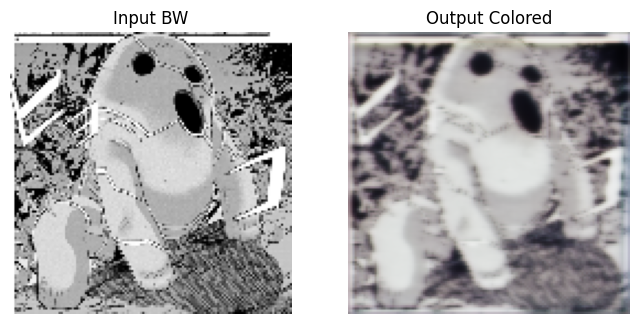

In [50]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Load model yang sudah dilatih
model = load_model('/content/drive/MyDrive/manga-dataset/manga_colorizer_unet.h5', compile=False)

# Fungsi uji gambar
def predict_bw_image(img_path):
    # Load dan normalisasi gambar BW
    bw_img = load_img(img_path, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))
    bw_array = img_to_array(bw_img) / 255.0
    bw_array = np.expand_dims(bw_array, axis=0)  # Add batch dimension
    bw_array = np.expand_dims(bw_array, axis=-1)  # Add channel dimension

    # Prediksi pewarnaan
    predicted_color = model.predict(bw_array)[0]

    # Tampilkan
    plt.figure(figsize=(8,4))
    plt.subplot(1, 2, 1)
    plt.title('Input BW')
    plt.imshow(bw_array[0].squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Output Colored')
    plt.imshow(predicted_color)
    plt.axis('off')

    plt.show()

# Upload gambar ke Colab
from google.colab import files
uploaded = files.upload()

# Ambil nama file pertama yang diupload
import io
from PIL import Image

for fname in uploaded.keys():
    print(f"Testing image: {fname}")
    predict_bw_image(fname)
